In [1]:
!pip install lifelines
!pip install scikit-survival

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=537fbd53db5d18b00943b43eb5ae46605cd320d60fa869534cbc055538524067
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\50\37\21\0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autoviz 0.1.905 requires xgboost<1.7,>=0.82, but you have xgboost 2.1.3 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.1 which is incompatible.
skimpy 0.0.18 requires numpy>=2.0.2, but you have numpy 1.26.4 which is incompatible.


   ---------------------------------------- 0.0/825.6 kB ? eta -:--:--
   --------------------------------------- 825.6/825.6 kB 17.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------------- -------------------------- 3.7/11.0 MB 19.8 MB/s eta 0:00:01
   --------------------------- ------------ 7.6/11.0 MB 19.6 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 18.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autoviz 0.1.905 requires xgboost<1.7,>=0.82, but you have xgboost 2.1.3 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from IPython.display import display
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sksurv.preprocessing import OneHotEncoder
from datetime import datetime
from lifelines.plotting import plot_lifetimes
from lifelines.utils import median_survival_times
from lifelines.statistics import multivariate_logrank_test
from lifelines import WeibullAFTFitter
import math

In [3]:
variants_df = pd.read_csv(r'C:\Users\dell\Desktop\MyDocs\Docs\MK\surv_variants.csv')

In [4]:
variants_df.head()

,Country,first_seq,num_seqs,last_seq,variant,censure_date,duration,censored,mortality_rate,total_cases,total_deaths,growth_rate
0,China,2019-10-22,3,2020-06-03,S.Q677,2020-06-21,225,True,0.052983,18259.460123,967.435583,16447.430706
1,USA,2020-03-03,26022,2021-11-19,S.Q677,2020-11-01,626,False,0.016111,256577.596234,4133.841031,84748.745876
2,Brazil,2020-03-09,1553,2021-11-12,S.Q677,2020-11-07,613,False,0.027846,101550.140466,2827.764288,42356.907426
3,Australia,2020-03-20,88,2021-11-14,S.Q677,2020-11-18,604,False,0.009905,1402.239579,13.889752,1227.122500
4,Sweden,2020-03-20,810,2021-11-19,S.Q677,2020-11-18,609,False,0.012711,1659.148728,21.089425,2521.042925


In [5]:
def detection_variant_mutation(data=None):
    """ 
        This function detecte variant and mutation 
        data: list variant and mutation
        
        return list variant and list mutation
    """
    isvariant = []
    ismutation = []
    for u in data:
        
        words = u.split('.')
        l1 = words[0]
        l2 = words[-1]
        cond1 = ('S' in words or l1=='S' or l2[0]=='S')
        cond2 = (l2[-1].isdigit() or l2[-1] =='-')
        cond3 = (l2[-2].isdigit())
        
        if  cond1 and cond2  and cond3 :
            ismutation.append(u)
        else:
            isvariant.append(u)
            
    return isvariant, ismutation

def transform_growth_rate(growth_rate):
    if growth_rate >=0:
        return np.arctan(np.log1p(growth_rate))
    else :
        return -np.arctan(np.log1p(-growth_rate))

In [6]:
def variant_type(row):
    if row in delta_variant:
        return 'Delta'
    elif row in s_variant:
        return 'S'
    elif row in other_variant:
        return 'Other'
    else:
        return 'mutation'
# Fonction pour simplifier la visualisation des courbes de Kaplan-Meier
def plot_kaplan_meier(df, group_col, title):
    plt.figure(figsize=(8, 6))
    for group in df[group_col].unique():
        subset = df[df[group_col] == group]
        time = subset['duration']
        event = subset['censored']
        time, survival_prob = kaplan_meier_estimator(event, time)
        plt.plot(time, survival_prob, label=f'{group}')
    plt.vlines(reference_duration , 0, 1, lw=1.5,
          linestyles='solid', 
          colors='black', 
          label='reference_duration=243 days')
    plt.legend()
    plt.xlabel("Time (days)")
    plt.ylabel("Survival probability")
    plt.title(title, fontsize=15, fontweight="bold")
    plt.legend()
    plt.show()

In [7]:
def continent_type(row):
    oceania = ['Fiji', 'Papua New Guinea', 'Vanuatu', 'New Zealand', 'Australia']
    africa = ['Tanzania', 'Congo (Kinshasa)', 'Somalia', 'Kenya', 'Sudan', 'Chad',
       'South Africa', 'Lesotho', 'Zimbabwe', 'Botswana', 'Namibia',
       'Senegal', 'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria',
       'Cameroon', 'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea','Cabo Verde',
       'Guinea-Bissau', 'Liberia', 'Sierra Leone', 'Burkina Faso',
       'Central African Republic', 'Congo (Brazzaville)', 'Gabon', 'Eq. Guinea', 
       'Zambia','Comoros','Equatorial Guinea','Mauritius',
       'Malawi', 'Mozambique', 'Eswatini', 'Angola', 'Burundi',
       'Madagascar', 'Gambia', 'Tunisia', 'Algeria', 'Eritrea', 'Morocco',
       'Egypt', 'Libya', 'Ethiopia', 'Djibouti', 'Uganda', 'Rwanda',
       'South Sudan']
    europe = ['Russia', 'Norway', 'France', 'Sweden', 'Belarus', 'Ukraine',
       'Poland', 'Austria', 'Hungary', 'Moldova', 'Romania', 'Lithuania',
       'Latvia', 'Estonia', 'Germany', 'Bulgaria', 'Greece', 'Albania',
       'Croatia', 'Switzerland', 'Luxembourg', 'Belgium', 'Netherlands',
       'Portugal', 'Spain', 'Ireland', 'Italy', 'Denmark','Dominican Republic'
       'UK', 'Iceland', 'Slovenia', 'Finland', 'Slovakia','Dominica',
       'Czech Republic', 'Bosnia and Herzegovina', 'Serbia', 'Montenegro', 'Kosovo']
    asia = ['Kazakhstan', 'Uzbekistan', 'Indonesia', 'Timor-Leste', 'Israel',
       'Lebanon', 'Jordan', 'United Arab Emirates', 'Qatar', 'Kuwait',
       'Iraq', 'Oman', 'Cambodia', 'Thailand', 'Laos', 'Vietnam',
       'South Korea', 'Mongolia', 'India', 'Bangladesh', 'Bhutan',
       'Nepal', 'Pakistan', 'Afghanistan', 'Tajikistan', 'Kyrgyzstan',
       'Iran', 'Syria', 'Armenia', 'Turkey', 'Sri Lanka', 'China',
       'Azerbaijan', 'Georgia', 'Philippines', 'Malaysia', 'Brunei',
       'Japan', 'Yemen', 'Saudi Arabia', 'Cyprus']
    namerica = ['Canada', 'USA', 'Haiti', 'Dominican Rep.',
       'Bahamas', 'Mexico', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Jamaica',
       'Cuba', 'Trinidad and Tobago']
    samerica = ['Argentina', 'Chile', 'Uruguay', 'Brazil', 'Bolivia', 'Peru',
       'Colombia', 'Venezuela', 'Guyana', 'Suriname', 'Ecuador',
       'Paraguay']
    
    if row in oceania:
        return 'Oceania'
    elif row in africa:
        return 'Africa'
    elif row in europe:
        return 'Europe'
    elif row in asia:
        return 'Asia'
    elif row in namerica:
        return 'North America'
    elif row in samerica:
        return 'South America'
    else:
        return 'Island/Country'

In [8]:
known_variants = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron', 'S']

In [9]:
group_variant, group_mutation = detection_variant_mutation(data=variants_df.variant.unique())

In [10]:
delta_variant = [u for u in group_variant if 'Delta' in u.split('.')]
s_variant = [u for u in group_variant if 'S' in u.split('.')]
other_variant = list(set(group_variant) - set(delta_variant+s_variant))

In [11]:
variants_df['variant_type'] = variants_df['variant'].apply(variant_type)

In [12]:
variant_counts = variants_df['variant'].value_counts()
total_countries = len(variants_df['Country'].unique())
variants_df['contamination_rate'] = variants_df['variant'].map(variant_counts) / total_countries

In [13]:
period_infectieuse = 14   
variants_df['transformed_growth_rate'] = variants_df['growth_rate'].apply(transform_growth_rate)
variants_df['R0_sir'] = 1 + variants_df['transformed_growth_rate'] * period_infectieuse
variants_df['R0_log'] = np.exp(variants_df['transformed_growth_rate'])

In [14]:
for column in ['mortality_rate','R0_sir','R0_log','growth_rate','contamination_rate']:
    variants_df[column] = variants_df[column].replace([np.inf, -np.inf], np.nan)
    variants_df[column] = variants_df[column].fillna(variants_df[column].mean())

# Calcul du R0 combiné
variants_df['R0'] = (
    (variants_df['R0_log'] - variants_df['R0_log'].mean()) / variants_df['R0_log'].std() +
    (variants_df['R0_sir'] - variants_df['R0_sir'].mean()) / variants_df['R0_sir'].std()
)/2


# Suppression des colonnes inutiles
variants_df = variants_df.drop(columns=['total_cases', 'total_deaths','transformed_growth_rate','R0_sir','R0_log'])

In [15]:
reference_duration = 243
# Calcul du numéro de vague
start_date_observation = datetime(2020, 1, 22) # la date du debut d enregistrement des données du SARS-CoV-II
variants_df['vague_number'] = 0
variants_df['number_of_variants'] = 0
for country in variants_df['Country'].unique():
    variants_country = variants_df[variants_df['Country']==country].sort_values(by='first_seq')
    for i,row in variants_country.iterrows():
        first_seq = row['first_seq'].split('-') 
        date_detection = datetime(int(first_seq[0]), int(first_seq[1]), int(first_seq[2]))
        period = abs(start_date_observation - date_detection)
        quotient = (row['duration'] //reference_duration)
        variants_df.loc[i,'vague_number'] = quotient+1 if period.days > reference_duration else quotient
    variants_df.loc[variants_df['Country']==country,'number_of_variants'] = len(variants_country)

In [16]:
variants_df['continent_type'] = variants_df.Country.apply(continent_type) 

In [17]:
variants_df.tail()

,Country,first_seq,num_seqs,last_seq,variant,censure_date,duration,censored,mortality_rate,growth_rate,variant_type,contamination_rate,R0,vague_number,number_of_variants,continent_type
4108,Kazakhstan,2021-08-17,88,2021-08-19,21J.Delta,2022-04-17,2,True,0.014838,7722.500000,Delta,0.853801,5.363773e-01,1,13,Asia
4109,Cyprus,2021-08-28,1,2021-08-28,21J.Delta,2022-04-28,0,True,0.004407,11682.192504,Delta,0.853801,6.602201e-16,1,12,Asia
4110,Guyana,2021-09-06,18,2021-09-08,21J.Delta,2022-05-07,2,True,0.024429,131.000000,Delta,0.853801,-7.084569e-02,1,12,South America
4111,Comoros,2021-10-05,11,2021-10-26,21J.Delta,2022-06-05,21,True,0.034727,3.152456,Delta,0.853801,-2.452964e+00,1,6,Africa
4112,Belarus,2021-10-27,1,2021-10-27,21J.Delta,2022-06-27,0,True,0.007705,11682.192504,Delta,0.853801,6.602201e-16,1,12,Europe


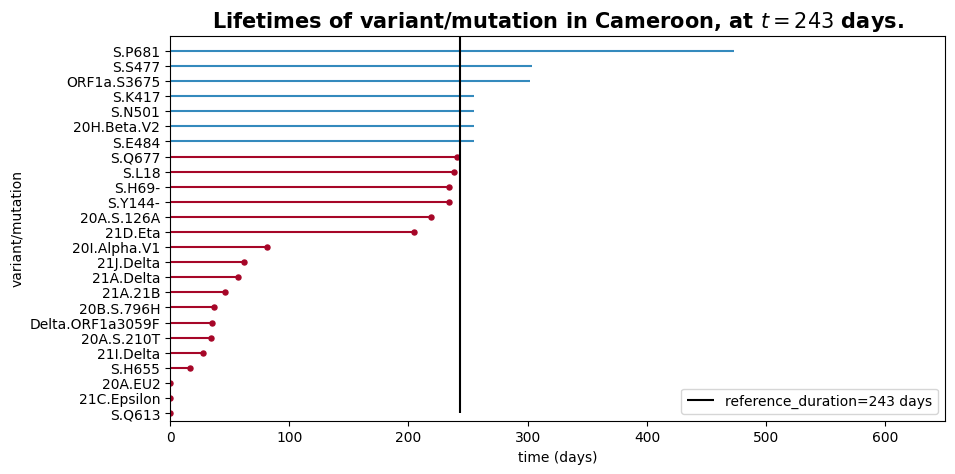

In [18]:
plt.figure(figsize=(10, 5))
cameroon = variants_df[variants_df.Country=='Cameroon'].sort_values(by='duration', ascending=False).set_index('variant')
ax = plot_lifetimes(cameroon.duration[:25] , event_observed=cameroon.censored[:25])
ax.set_xlim(0, 650)
ax.vlines(reference_duration , 0, 58, lw=1.5, linestyles='solid',
          colors='black', label='reference_duration=243 days')
ax.set_xlabel("time (days)")
ax.set_ylabel("variant/mutation")
ax.set_title(f"Lifetimes of variant/mutation in Cameroon, at $t={reference_duration}$ days.",
            fontsize=15, fontweight='bold')
plt.legend(loc='lower right');

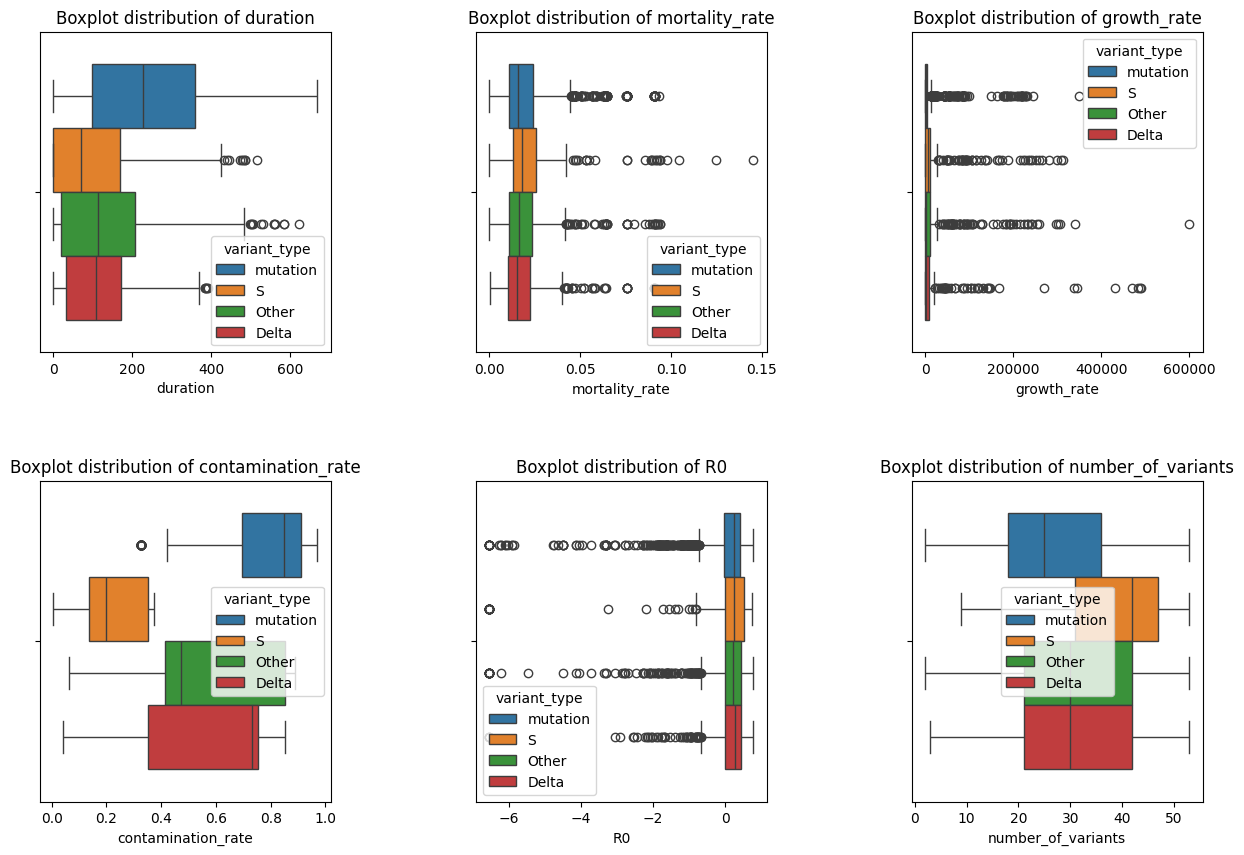

In [19]:
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.5)
cols = ['duration', 'mortality_rate', 'growth_rate','contamination_rate',
        'R0', 'number_of_variants']
for i, column in enumerate(cols):
    ax = fig.add_subplot(2, 3, i+1)
    sns.boxplot(x=column, data=variants_df,hue='variant_type', ax=ax)
    ax.set_title(f'Boxplot distribution of {column}')
plt.show()

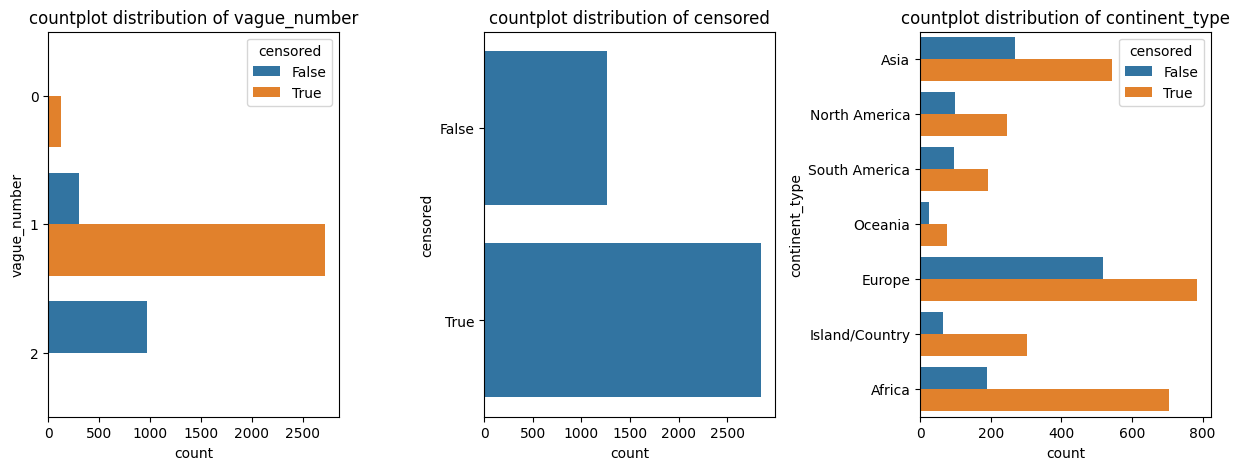

In [20]:
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=0.5)
objcols = ['vague_number', 'censored', 'continent_type']
for i, column in enumerate(objcols):
    ax = fig.add_subplot(1, 3, i+1)
    sns.countplot(y=column, data=variants_df, hue='censored' if column != 'censored' else None , 
                  ax=ax)
    ax.set_title(f'countplot distribution of {column}')
plt.show()

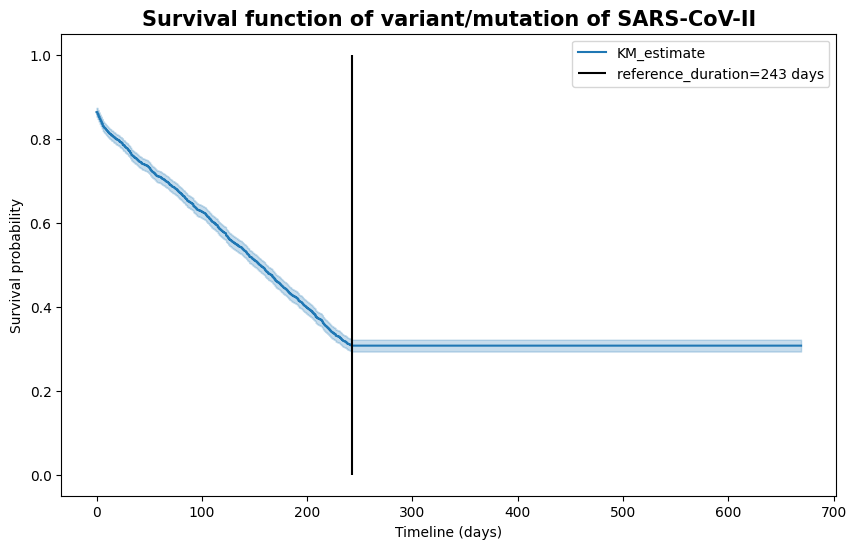

In [21]:
plt.figure(figsize=(10,6))
kmf = KaplanMeierFitter()
kmf.fit(variants_df.duration, event_observed=variants_df.censored)
#kmf.survival_function_.plot()
kmf.plot_survival_function()
plt.vlines(reference_duration , 0, 1, lw=1.5,
          linestyles='solid', 
          colors='black', 
          label='reference_duration=243 days')
plt.legend()
plt.ylabel('Survival probability')
plt.xlabel('Timeline (days)')
plt.title('Survival function of variant/mutation of SARS-CoV-II', fontsize=15,fontweight='bold');

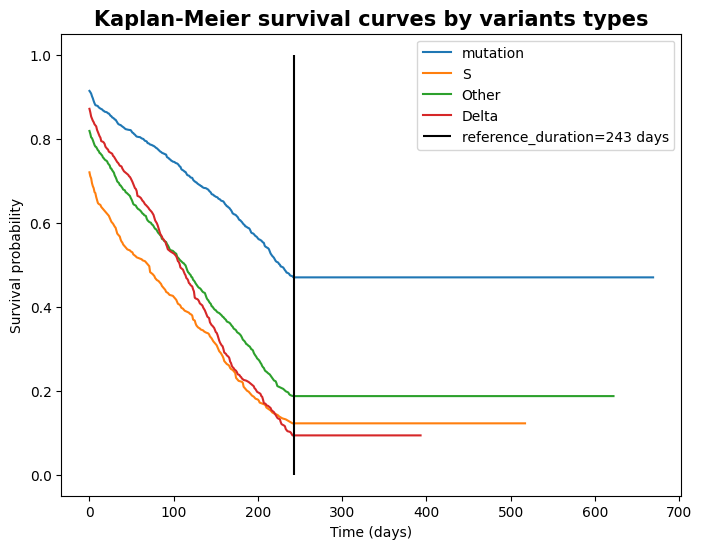

In [22]:
plot_kaplan_meier(variants_df, 'variant_type', "Kaplan-Meier survival curves by variants types")

In [23]:
results = multivariate_logrank_test(variants_df.duration, variants_df.variant_type, 
                                    variants_df.censored)
results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         618.27 <0.005    441.67

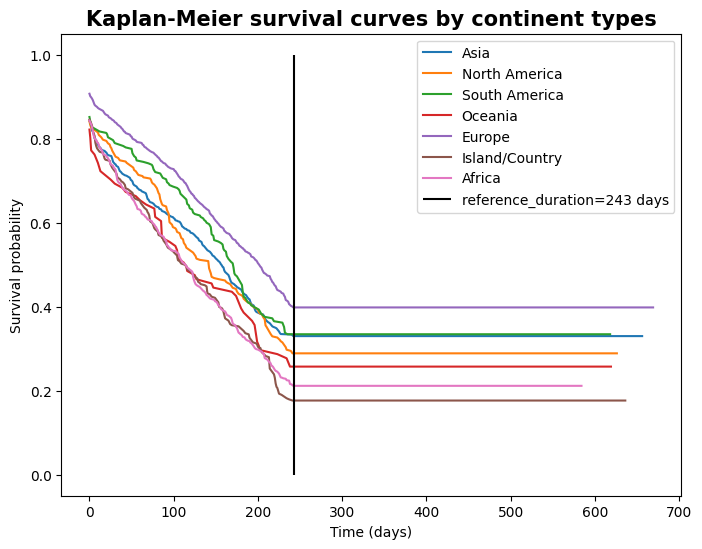

In [24]:
plot_kaplan_meier(variants_df, 'continent_type', "Kaplan-Meier survival curves by continent types")

In [25]:
results = multivariate_logrank_test(variants_df.duration, variants_df.continent_type, 
                                    variants_df.censored)
results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 6
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         147.85 <0.005     95.19

In [26]:
features = ['mortality_rate','R0','growth_rate','num_seqs','contamination_rate',
            'vague_number','number_of_variants',
           'censored', 'duration']
encoder = OneHotEncoder()
encoded_variants = encoder.fit_transform(variants_df[['variant_type', 'continent_type']].astype('category'))
X = pd.concat((variants_df[features], encoded_variants), axis=1)

In [27]:
%%time
cph = CoxPHFitter()
cph.fit(X, duration_col='duration', event_col='censored')
cph.summary

CPU times: total: 688 ms
Wall time: 851 ms


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
mortality_rate,-3.451289e+00,0.031705,1.411624e+00,-6.218022e+00,-0.684557,0.001993,0.504314,0.0,-2.444907,1.448896e-02,6.108902
R0,-1.888712e-01,0.827893,1.808519e-02,-2.243176e-01,-0.153425,0.799061,0.857765,0.0,-10.443418,1.570515e-25,82.396965
growth_rate,9.536747e-07,1.000001,5.861440e-07,-1.951465e-07,0.000002,1.000000,1.000002,0.0,1.627031,1.037305e-01,3.269089
num_seqs,-5.083272e-05,0.999949,1.098411e-05,-7.236119e-05,-0.000029,0.999928,0.999971,0.0,-4.627839,3.695003e-06,18.045993
contamination_rate,-2.306839e+00,0.099575,1.139470e-01,-2.530171e+00,-2.083507,0.079645,0.124493,0.0,-20.244844,3.944277e-91,300.315696
vague_number,-1.108213e+00,0.330149,4.519625e-02,-1.196796e+00,-1.019630,0.302161,0.360729,0.0,-24.520013,9.037397e-133,438.640529
number_of_variants,-5.305823e-02,0.948325,2.443220e-03,-5.784686e-02,-0.048270,0.943794,0.952877,0.0,-21.716517,1.432356e-104,344.962132
variant_type=Other,-5.240327e-01,0.592128,5.706651e-02,-6.358810e-01,-0.412184,0.529469,0.662202,0.0,-9.182841,4.198669e-20,64.368630
variant_type=S,-9.904794e-01,0.371399,8.189031e-02,-1.150981e+00,-0.829977,0.316326,0.436059,0.0,-12.095197,1.119735e-33,109.460469


In [28]:
%%time
cph.check_assumptions(X, show_plots=False)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4113 total observations, 1264 right-censored observations>
         test_name = proportional_hazard_test

---
                                    test_statistic      p  -log2(p)
R0                            km              3.80   0.05      4.29
                              rank            4.71   0.03      5.06
contamination_rate            km            127.62 <0.005     95.89
                              rank          131.54 <0.005     98.75
continent_type=Asia           km              0.07   0.79      0.34
                              rank            0.10   0.76      0.40
continent_type=Europe         km              1.26   0.26      1.94
                              rank            1.67   0.20      2.35
continent_type=Island/Country km              7.93 <0.005      7.68
                              rank            7.82   0.01      7.60
continent_type=North America  km             16.84 <0.005     14.59
                              rank           16.48 <0.005     14.31
continent_type=Oceania        km              0.35   0.55      0.85
                              rank            0.52   0.47      1.08
continent_type=South America  km             24.04 <0.005     20.01
                              rank           20.49 <0.005     17.35
growth_rate                   km              3.95   0.05      4.41
                              rank            3.61   0.06      4.12
mortality_rate                km              6.99   0.01      6.93
                              rank            7.56   0.01      7.39
num_seqs                      km             74.82 <0.005     57.43
                              rank           65.42 <0.005     50.55
number_of_variants            km             49.61 <0.005     38.96
                              rank           43.63 <0.005     34.55
vague_number                  km            280.32 <0.005    206.60
                              rank          263.37 <0.005    194.33
variant_type=Other            km             30.10 <0.005     24.54
                              rank           24.39 <0.005     20.28
variant_type=S                km             43.97 <0.005     34.81
                              rank           41.88 <0.005     33.26
variant_type=mutation         km             96.28 <0.005     73.09
                              rank           94.33 <0.005     71.66



1. Variable 'mortality_rate' failed the non-proportional test: p-value is 0.0060.

   Advice 1: the functional form of the variable 'mortality_rate' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'mortality_rate' using pd.cut, and then specify it in
`strata=['mortality_rate', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'num_seqs' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'num_seqs' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how

[]

In [29]:
from lifelines.utils import to_long_format
from lifelines import CoxTimeVaryingFitter

In [30]:
X_df = to_long_format(X, duration_col="duration")

In [31]:
X_df.loc[ (X_df['start'] == X_df['stop']) & (X_df['start'] == 0) & X_df['censored'], 'stop'] = 10/24

C:\Users\dell\AppData\Local\Temp\ipykernel_16736\707215819.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4166666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_df.loc[ (X_df['start'] == X_df['stop']) & (X_df['start'] == 0) & X_df['censored'], 'stop'] = 10/24


In [32]:
X_df.head()

,mortality_rate,R0,growth_rate,num_seqs,contamination_rate,vague_number,number_of_variants,censored,variant_type=Other,variant_type=S,variant_type=mutation,continent_type=Asia,continent_type=Europe,continent_type=Island/Country,continent_type=North America,continent_type=Oceania,continent_type=South America,start,stop
0,0.052983,0.595689,16447.430706,3,0.80117,0,25,True,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,225.0
1,0.016111,0.698148,84748.745876,26022,0.80117,2,53,False,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,626.0
2,0.027846,0.658507,42356.907426,1553,0.80117,2,38,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,613.0
3,0.009905,0.342582,1227.122500,88,0.80117,2,44,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,604.0
4,0.012711,0.428665,2521.042925,810,0.80117,2,46,False,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,609.0


In [33]:
%%time
ctv = CoxTimeVaryingFitter(penalizer=0.01)
ctv.fit(X_df, event_col="censored", start_col="start", stop_col="stop", show_progress=True)
ctv_without_interaction = ctv.summary
ctv.summary

Iteration 1: norm_delta = 1.13e+00, step_size = 0.9500, log_lik = -22352.06313, newton_decrement = 1.54e+03, seconds_since_start = 0.3
Iteration 2: norm_delta = 3.26e-01, step_size = 0.9500, log_lik = -20984.56349, newton_decrement = 2.05e+02, seconds_since_start = 0.5
Iteration 3: norm_delta = 1.28e-01, step_size = 0.9500, log_lik = -20760.60655, newton_decrement = 1.93e+01, seconds_since_start = 0.7
Iteration 4: norm_delta = 2.12e-01, step_size = 1.0000, log_lik = -20738.95545, newton_decrement = 4.28e+00, seconds_since_start = 1.0
Iteration 5: norm_delta = 1.49e-01, step_size = 0.9800, log_lik = -20733.62531, newton_decrement = 9.50e-01, seconds_since_start = 1.2
Iteration 6: norm_delta = 1.69e-02, step_size = 0.9604, log_lik = -20732.62358, newton_decrement = 1.12e-02, seconds_since_start = 1.5
Iteration 7: norm_delta = 8.27e-04, step_size = 1.0000, log_lik = -20732.61237, newton_decrement = 2.45e-05, seconds_since_start = 1.7
Iteration 8: norm_delta = 2.82e-07, step_size = 1.0000,

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
mortality_rate,-3.251013e+00,0.038735,1.393503e+00,-5.982229e+00,-0.519798,0.002523,0.594641,0.0,-2.332980,1.964922e-02,5.669384
R0,-1.870392e-01,0.829411,1.792469e-02,-2.221710e-01,-0.151907,0.800778,0.859068,0.0,-10.434728,1.721065e-25,82.264901
growth_rate,5.139735e-07,1.000001,5.892946e-07,-6.410226e-07,0.000002,0.999999,1.000002,0.0,0.872184,3.831078e-01,1.384178
num_seqs,-1.188179e-05,0.999988,3.024607e-06,-1.780991e-05,-0.000006,0.999982,0.999994,0.0,-3.928376,8.552158e-05,13.513352
contamination_rate,-2.289200e+00,0.101348,1.094301e-01,-2.503679e+00,-2.074721,0.081784,0.125591,0.0,-20.919290,3.573977e-97,320.389495
vague_number,-1.111980e+00,0.328907,4.431839e-02,-1.198842e+00,-1.025117,0.301543,0.358754,0.0,-25.090702,6.282637e-139,459.096635
number_of_variants,-5.276255e-02,0.948605,2.345311e-03,-5.735927e-02,-0.048166,0.944255,0.952976,0.0,-22.497040,4.437014e-112,369.906358
variant_type=Other,-4.757115e-01,0.621443,5.624161e-02,-5.859430e-01,-0.365480,0.556581,0.693864,0.0,-8.458354,2.711777e-17,55.033539
variant_type=S,-9.112726e-01,0.402012,8.044372e-02,-1.068939e+00,-0.753606,0.343372,0.470666,0.0,-11.328076,9.527416e-30,96.405758


In [34]:
intercols = ['variant_type=Other', 'variant_type=S', 'variant_type=mutation',
       'continent_type=Asia', 'continent_type=Europe',
       'continent_type=Island/Country', 'continent_type=North America',
       'continent_type=Oceania', 'continent_type=South America']
icols = ['mortality_rate', 'R0', 'growth_rate', 'num_seqs', 'contamination_rate',
       'vague_number', 'number_of_variants']

In [35]:
interaction = X.copy()
for u in icols:
    for v in intercols:
        word = v.split('=')
        interaction[f'{u}*{v}'] = interaction[u]*interaction[v]

In [36]:
interaction_df = to_long_format(interaction, duration_col="duration")

In [37]:
interaction_df.loc[ (interaction_df['start'] == interaction_df['stop']) & (interaction_df['start'] == 0) & interaction_df['censored'], 'stop'] = 10/24

C:\Users\dell\AppData\Local\Temp\ipykernel_16736\2682013814.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4166666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  interaction_df.loc[ (interaction_df['start'] == interaction_df['stop']) & (interaction_df['start'] == 0) & interaction_df['censored'], 'stop'] = 10/24


In [38]:
%%time
ctv1 = CoxTimeVaryingFitter(penalizer=0.01)
ctv1.fit(interaction_df, event_col="censored", start_col="start", stop_col="stop", show_progress=True)
ctv_with_interaction = ctv1.summary
ctv1.summary

Iteration 1: norm_delta = 1.70e+00, step_size = 0.9500, log_lik = -22352.06313, newton_decrement = 1.83e+03, seconds_since_start = 1.0
Iteration 2: norm_delta = 1.49e+01, step_size = 0.9500, log_lik = -25546.49250, newton_decrement = 5.90e+04, seconds_since_start = 2.0
Iteration 3: norm_delta = 3.41e+01, step_size = 0.2375, log_lik = -78128.57646, newton_decrement = 8.48e+05, seconds_since_start = 3.4
Iteration 4: norm_delta = 2.56e+01, step_size = 0.0303, log_lik = -350422.64138, newton_decrement = 1.60e+07, seconds_since_start = 4.4
Iteration 5: norm_delta = 1.21e+00, step_size = 0.0039, log_lik = -232634.98256, newton_decrement = 2.62e+06, seconds_since_start = 5.2
Iteration 6: norm_delta = 1.57e+00, step_size = 0.0065, log_lik = -212491.68436, newton_decrement = 1.50e+06, seconds_since_start = 6.0
Iteration 7: norm_delta = 1.89e+00, step_size = 0.0083, log_lik = -192971.09433, newton_decrement = 1.34e+06, seconds_since_start = 6.9
Iteration 8: norm_delta = 1.82e+00, step_size = 0.0

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
mortality_rate,-0.036458,0.964199,3.891415,-7.663492,7.590576,0.000470,1979.453688,0.0,-0.009369,9.925249e-01,0.010825
R0,-0.194675,0.823102,0.065431,-0.322918,-0.066432,0.724033,0.935726,0.0,-2.975266,2.927350e-03,8.416189
growth_rate,0.000010,1.000010,0.000003,0.000005,0.000016,1.000005,1.000016,0.0,3.686015,2.277932e-04,12.099987
num_seqs,-0.000005,0.999995,0.000004,-0.000012,0.000002,0.999988,1.000002,0.0,-1.340163,1.801922e-01,2.472392
contamination_rate,-2.012416,0.133665,0.193955,-2.392561,-1.632271,0.091395,0.195485,0.0,-10.375678,3.199332e-25,81.370432
...,...,...,...,...,...,...,...,...,...,...,...
number_of_variants*continent_type=Europe,0.002251,1.002253,0.004835,-0.007226,0.011728,0.992800,1.011797,0.0,0.465464,6.415992e-01,0.640256
number_of_variants*continent_type=Island/Country,0.005472,1.005487,0.007414,-0.009060,0.020004,0.990981,1.020205,0.0,0.737967,4.605345e-01,1.118619
number_of_variants*continent_type=North America,0.001016,1.001017,0.008049,-0.014759,0.016791,0.985350,1.016933,0.0,0.126240,8.995423e-01,0.152737
